# 导入

In [1]:
import pandas as pd

In [2]:
from zipline.api import *

In [3]:
from zipline.algorithm import log

# 黑名单

In [4]:
from zipline.pipeline.builtin import BlackNames

In [5]:
# 默认为空，可根据需要添加股票黑名单代码，如['000033']
black_stocke = []

In [6]:
bns = BlackNames(black_stocke)

# 策略

## `pipeline`

In [7]:
from zipline.pipeline import Pipeline
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.factors import SimpleMovingAverage
from zipline.pipeline.builtin import QTradableStocks

In [8]:
def make_pipeline():
    """
    创建pipeline
    """
    # Base universe set to the QTradableStocksUS.
    base_universe = QTradableStocks()

    return Pipeline(
        columns={
#             'close':USEquityPricing.close.latest
        },
        screen=base_universe & (~bns),
    )


## `initialize`

In [9]:
def initialize(context):
    attach_pipeline(make_pipeline(), 'pipeline_data')
    # 计划函数
    schedule_function(rebalance, 
                      date_rules.week_start(days_offset=0),
                      time_rules.market_open(hours = 1, minutes = 30)) 

## `before_trading_start`

In [10]:
def before_trading_start(context, data):
    # 存储pipeline输出结果(DataFrame)到上下文
    context.output = pipeline_output('pipeline_data')

## `handle_data`

In [11]:
def handle_data(context, data):
    # 策略逻辑
    # ...
    pass
    # ...

## 计划函数

In [12]:
def rebalance(context, data):

    # Do the rebalance. Loop through each of the stocks and order to
    # the target percentage.  If already at the target, this command 
    # doesn't do anything. A future improvement could be to set rebalance
    # thresholds.
#     for sec in context.security_list:
#         if data.can_trade(sec):
#             order_target_percent(sec, context.weights)

    # Get the current exchange time, in the exchange timezone 
    exchange_time = get_datetime('Asia/Shanghai')
    log.info("Rebalanced to target portfolio weights at %s" % str(exchange_time))

# 运行

In [13]:
import ipywidgets as widgets
from ipywidgets import Layout
import datetime

## 捕获输出

In [14]:
out = widgets.Output() # 记录日志

## 开始日期

In [15]:
start_date_picker = widgets.DatePicker(
    disabled=False,
    value=datetime.date.today()-datetime.timedelta(days=365)
)

## 结束日期

In [16]:
end_date_picker = widgets.DatePicker(
    disabled=False,
    value=datetime.date.today(),
)

## 初始资本

In [17]:
capitalbase_picker = widgets.BoundedFloatText(
    value=1000000,
    min=10000,
    max=99990000,
    step=10000,
    description='',
    disabled=False
)

## 基准指数

In [18]:
from cswd.websource.wy import get_main_index

In [19]:
main_index = get_main_index()

In [20]:
main_index_picker = widgets.Select(
    options=['{} {}'.format(k, v) for k,v in main_index['name'].items()],
    value='000002 A股指数',
    description='',
    disabled=False
)

## 文件名称

In [21]:
file_name_text = widgets.Text(
    placeholder='请输入策略文件名',
    disabled=False,
    layout=Layout(width='150px')
)

## 运行

In [22]:
run_btn = widgets.Button(
    description='运行回测',
    disabled=False,
    button_style='info',
    tooltip='点击按钮，运行完整回测，获取回测详细指标',
)

In [23]:
from IPython.display import display

In [24]:
btn_items = [start_date_picker, end_date_picker, capitalbase_picker, main_index_picker, run_btn]
init_btns = widgets.HBox(btn_items)

## 回测辅助函数

In [25]:
from zipline import run_algorithm
from zipline.research.core import (
    bundle,
)
from zipline.pipeline.loaders.blaze import global_loader

In [26]:
@out.capture()
def get_algo_result():
    return run_algorithm(
        start=pd.Timestamp(start_date_picker.value, tz='utc'),
        end=pd.Timestamp(end_date_picker.value, tz='utc'),
        initialize=initialize,
        capital_base=capitalbase_picker.value,
        handle_data=handle_data,
        before_trading_start=before_trading_start,
#         data=data_portal,
        bundle=bundle,
        bm_symbol=main_index_picker.value.split()[0],
    )

In [27]:
def on_button_clicked(b):
    # 是按钮失效，防止重复点击
    b.disabled = True

    # 运行回测
    get_algo_result()
    
    # 恢复按钮
    b.disabled = False

run_btn.on_click(on_button_clicked)

In [28]:
display(init_btns)

# 运行结果

## 日志

In [29]:
out

Output()

## 分析

In [34]:
from zipline.research import get_latest_backtest_info, get_backtest

### 最近成功运行回测的时间

In [39]:
get_latest_backtest_info()[1]

Timestamp('2018-06-17 13:32:31+0800', tz='Asia/Shanghai')

### 回测结果

In [36]:
df = get_backtest()

最大回撤,净回撤百分比,波峰日期,波谷日期,回本日期,回本天数
0,0.16,2018-04-12,2018-04-17,2018-04-19,6
1,0.13,2018-04-20,2018-04-23,2018-04-24,3
2,0.02,2018-04-24,2018-04-25,NaT,NaN
3,0.00,2018-04-11,2018-04-11,2018-04-11,1
4,0.00,2018-04-11,2018-04-11,2018-04-11,1


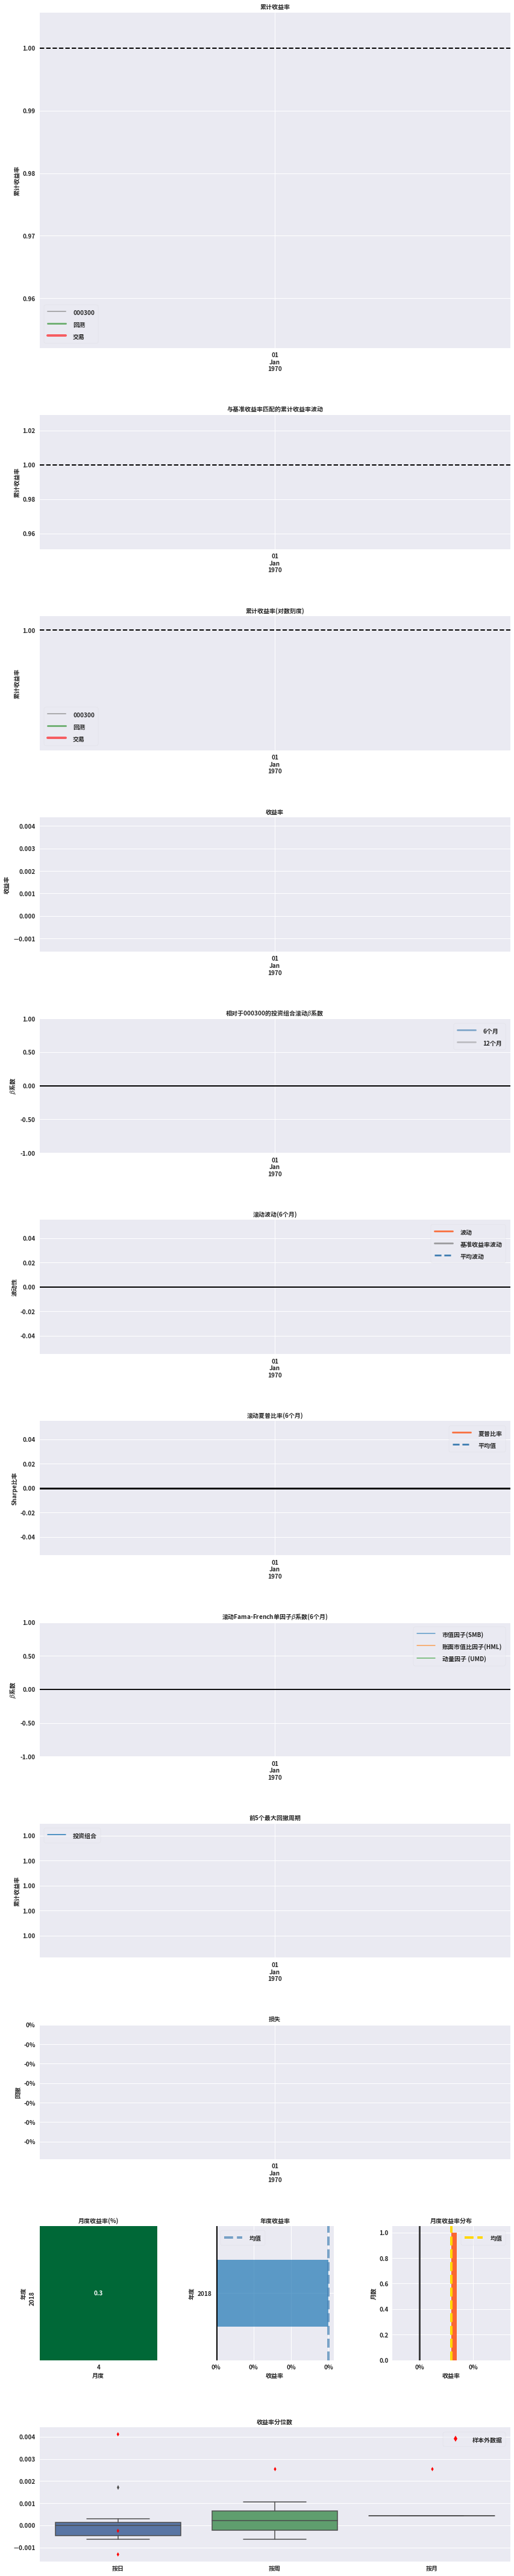

前十位多头头寸,max
sid,
000333,5.77%
600771,5.64%
600000,1.28%
000157,0.46%


前十位空头头寸,max
sid,


前十位总头寸,max
sid,
000333,5.77%
600771,5.64%
600000,1.28%
000157,0.46%


历史总头寸,max
sid,
000333,5.77%
600771,5.64%
600000,1.28%
000157,0.46%


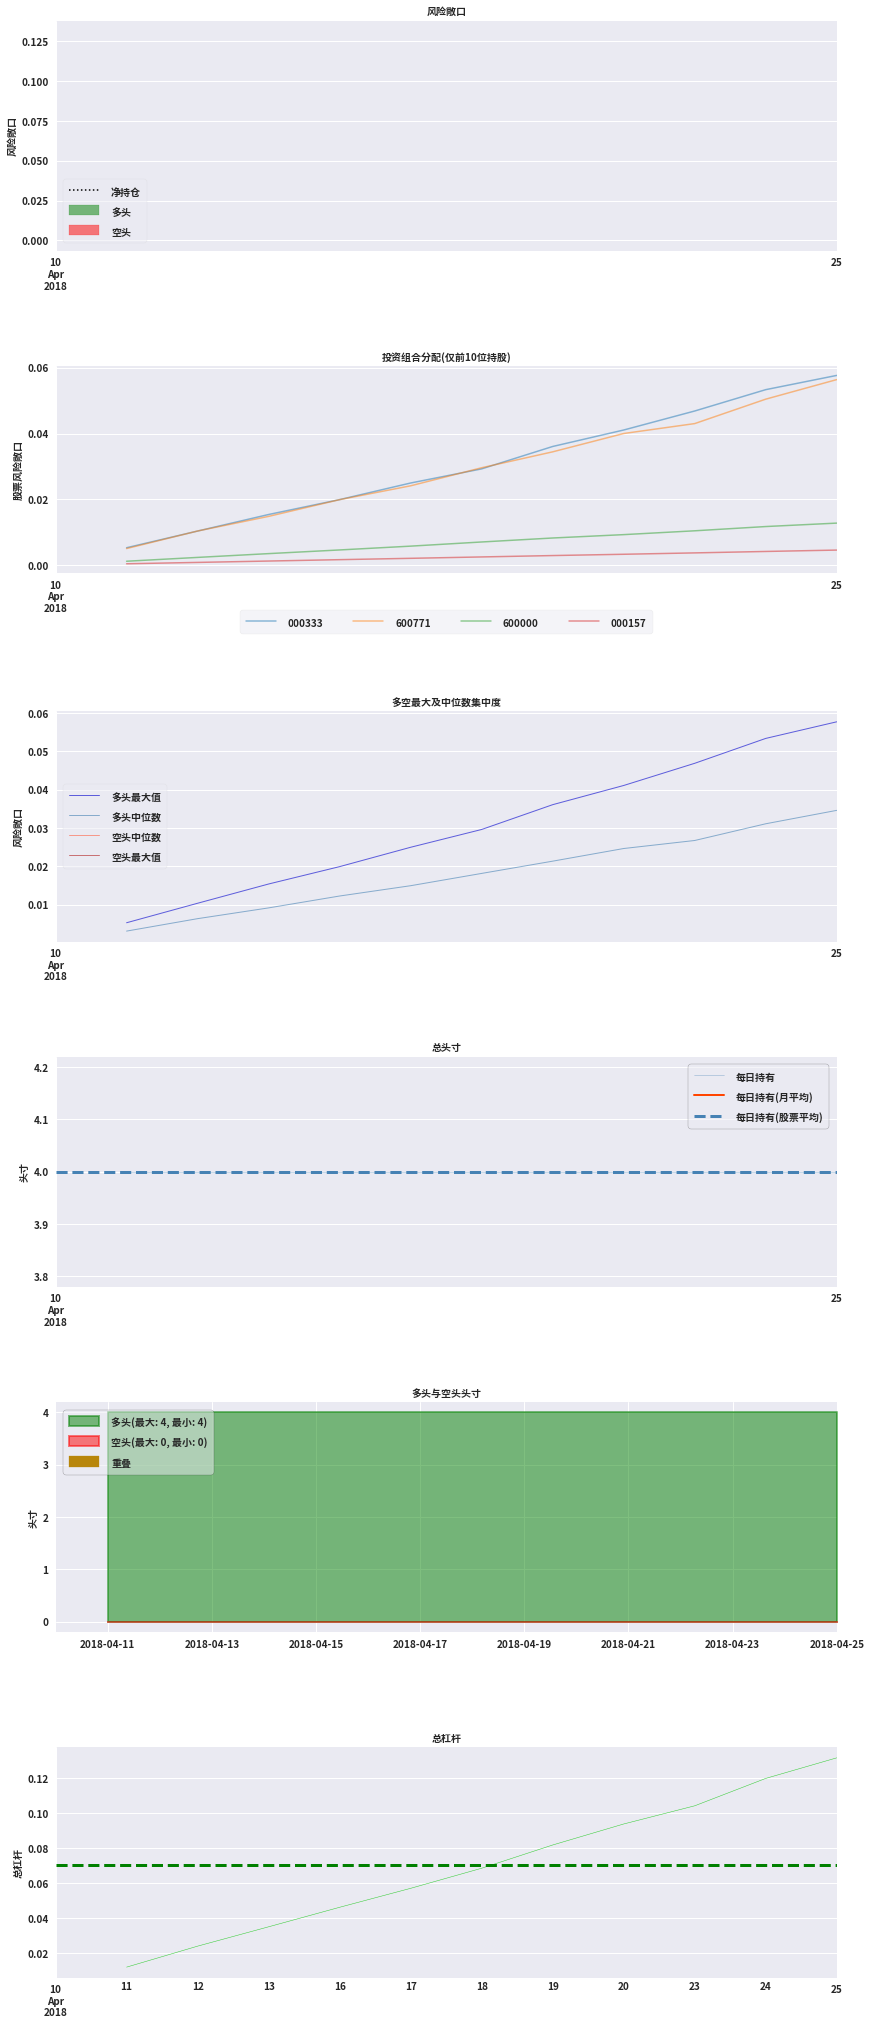

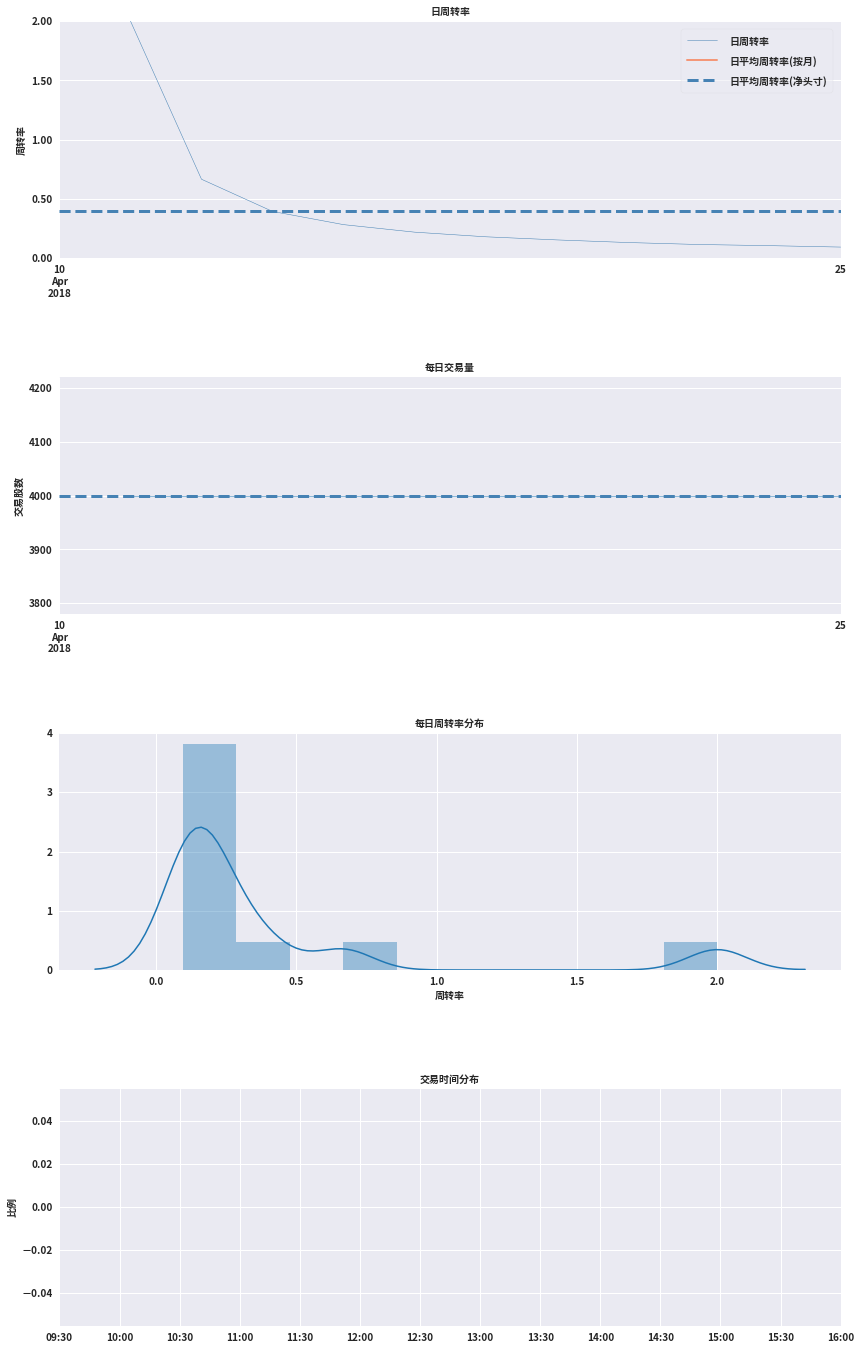

概要统计,所有交易,空头交易,多头交易
完成交易总数,8.00,4.00,4.00
盈利比率,0.38,0.00,0.75
盈利次数,3.00,0.00,3.00
亏损次数,5.00,4.00,1.00
持平次数,0.00,0.00,0.00


盈亏统计,所有交易,空头交易,多头交易
总利润,¥29915.72,¥-59.96,¥29975.68
毛利润,¥30434.18,¥0.00,¥30434.18
毛亏损,¥-518.46,¥-59.96,¥-458.50
盈亏因子,¥58.70,¥0.00,¥66.38
平均交易净利润,¥3739.46,¥-14.99,¥7493.92
盈利交易平均值,¥10144.73,¥nan,¥10144.73
亏损交易平均值,¥-103.69,¥-14.99,¥-458.50
盈亏均值因子,¥97.84,¥nan,¥22.13
交易最大盈利,¥17511.58,¥-2.09,¥17511.58
交易最大亏损,¥-458.50,¥-26.31,¥-458.50


周期统计,所有交易,空头交易,多头交易
平均周期,7 days 00:00:00,06:59:59,13 days 17:00:01
中位数周期,7 days 00:00:00,06:59:59,13 days 17:00:01
最长周期,13 days 17:00:01,06:59:59,13 days 17:00:01
最短周期,0 days 06:59:59,06:59:59,13 days 17:00:01


收益率统计,所有交易,空头交易,多头交易
所有已完成交易平均收益率,0.04%,-0.00%,0.07%
盈利交易平均收益率,0.10%,nan%,0.10%
亏损交易平均收益率,-0.00%,-0.00%,-0.00%
所有已完成交易中位数收益率,-0.00%,-0.00%,0.06%
盈利交易中位数收益率,0.13%,nan%,0.13%
亏损交易中位数收益率,-0.00%,-0.00%,-0.00%
最大盈利率,0.17%,-0.00%,0.17%
最大亏损率,-0.00%,-0.00%,-0.00%


个股统计,000157,000333,600000,600771
所有已完成交易平均收益率,0.00%,0.06%,-0.00%,0.09%
盈利交易平均收益率,0.00%,0.13%,nan%,0.17%
亏损交易平均收益率,-0.00%,-0.00%,-0.00%,-0.00%
所有已完成交易中位数收益率,0.00%,0.06%,-0.00%,0.09%
盈利交易中位数收益率,0.00%,0.13%,nan%,0.17%
亏损交易中位数收益率,-0.00%,-0.00%,-0.00%,-0.00%
最大盈利率,0.00%,0.13%,-0.00%,0.17%
最大亏损率,-0.00%,-0.00%,-0.00%,-0.00%


个股盈利能力(合计PnL/PnL),
symbol,
600771,58.45%
000333,42.68%
000157,0.42%
600000,-1.55%


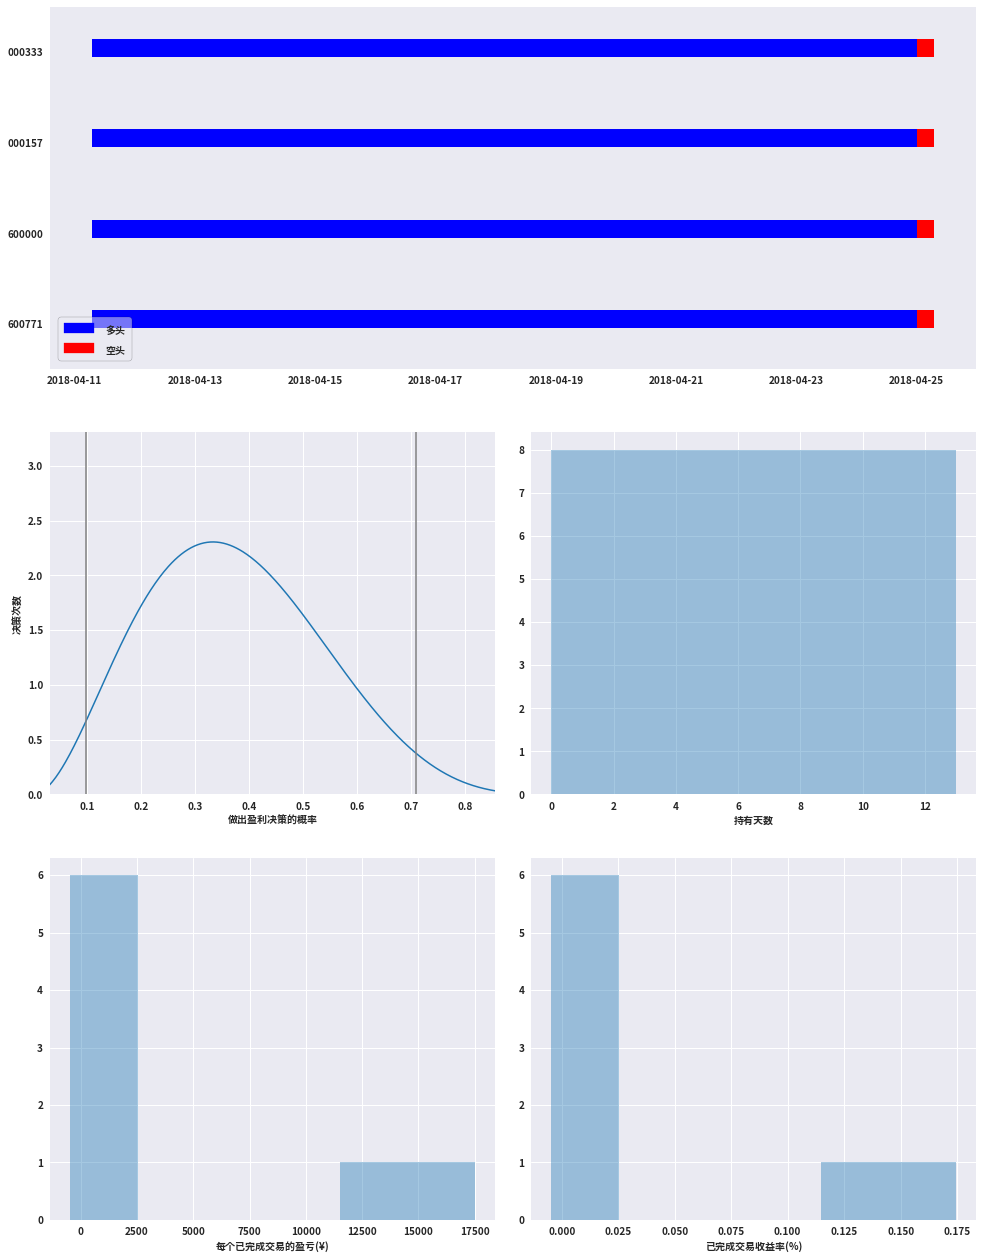

In [37]:
df.create_full_tear_sheet()